<a href="https://colab.research.google.com/github/orannahum/Transfer-Learning/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Packages

In [ ]:
!pip install --upgrade tensorflow_hub
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import itertools


## 2. Load Data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteOG4OMO/horses_or_humans-train.tfrecord


  0%|          | 0/1027 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteOG4OMO/horses_or_humans-test.tfrecord


  0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.
Train dataset size: 1027
Test dataset size: 256
['image', 'label']
(300, 300, 3) tf.Tensor(0, shape=(), dtype=int64)
x_train shape: (1027, 300, 300, 3)
x_test shape: (256, 300, 300, 3)
y_train shape: (1027, 2)
y_test shape: (256, 2)


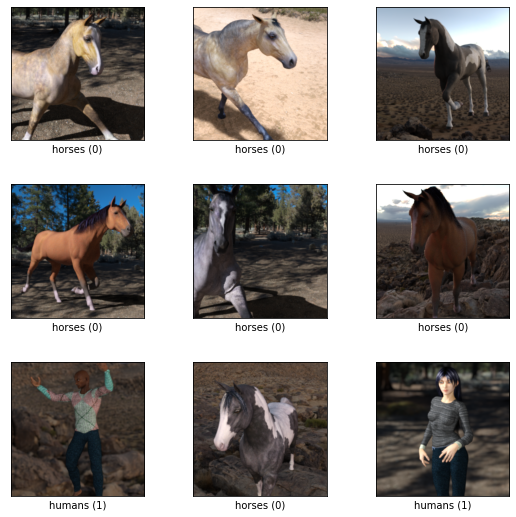

In [ ]:
(train_dataset, test_dataset), dataset_info = (
    tfds.load('horses_or_humans', split=['train', 'test'], shuffle_files=True, with_info=True))

# Check size of dataset
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Visualize the structure of the data
for example in train_dataset.take(1):
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)

# Convert to our known format
train_numpy = list(tfds.as_numpy(train_dataset))
x_train = np.array([sample['image'] for sample in train_numpy])
y_train = np.array([sample['label'] for sample in train_numpy])

test_numpy = list(tfds.as_numpy(test_dataset))
x_test = np.array([sample['image'] for sample in test_numpy])
y_test = np.array([sample['label'] for sample in test_numpy])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Print shapes
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Visualize a few samples from the dataset
_ = tfds.visualization.show_examples(train_dataset, dataset_info)

# For a less pretty but more methodical view, try:
# tfds.as_dataframe(train_dataset.take(10), dataset_info)

## 3. Define Parameters 

In [ ]:
num_classes = 2         # number of classes
hidden_size = 256       # number of neurons in the hidden layer
lr = 1e-4               # learning rate
epochs = 10             # number of epochs
batch_size = 16         # batch size
dropout = 0.4           # Dropout percentage to use


## 4. Build Model using Sequential

In [ ]:
inception_v3 = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4", trainable=False)
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.),
    inception_v3,
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(hidden_size, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])  # Batch input shape.


##  5. Train the Model

In [ ]:
# define the optimizer and compile the model
adam = optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model, iterating on the data in batches of 64 samples
history = model.fit(x_train, y_train, validation_split=0.3, epochs=epochs, batch_size=batch_size)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
45/45 [==============================] - 46s 219ms/step - loss: 0.1931 - accuracy: 0.9234 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 2/10
45/45 [==============================] - 7s 147ms/step - loss: 0.0204 - accuracy: 0.9958 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 7s 147ms/step - loss: 0.0136 - accuracy: 0.9986 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 7s 147ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 7s 147ms/step - loss: 0.0079 - accuracy: 0.9986 - val_loss: 7.3168e-04 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 7s 147ms/step - loss: 0.0095 - accuracy: 0.9958 - val_loss: 6.5174e-04 - val_accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 7s 147ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.9999e-04 - val_accuracy: 

## 6. Visualize

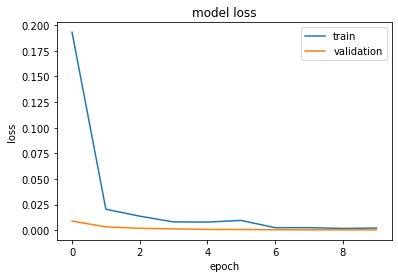

In [ ]:
# plot train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show(); plt.close()


## 7. Model Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print results
print('test loss:', test_loss)
print('test accuracy:', test_acc)

8/8 [==============================] - 4s 171ms/step - loss: 0.0045 - accuracy: 1.0000
test loss: 0.00445895129814744
test accuracy: 1.0
